In [6]:
import pandas as pd

In [7]:
import csv
train_df = pd.read_csv('/kaggle/input/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/dataset/test.csv')

In [8]:

train_df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [9]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [11]:

from transformers import RobertaModel, RobertaTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.0146082994902705
Epoch 2, Loss: 0.6035895376187849
Epoch 3, Loss: 0.540433736744842
Epoch 4, Loss: 0.4584617139668482
Epoch 5, Loss: 0.36878863295945735
Epoch 6, Loss: 0.2876509439571317
Epoch 7, Loss: 0.22445868703492014
Epoch 8, Loss: 0.17536986187595283
Epoch 9, Loss: 0.1405014549124285
Epoch 10, Loss: 0.11947169539783274


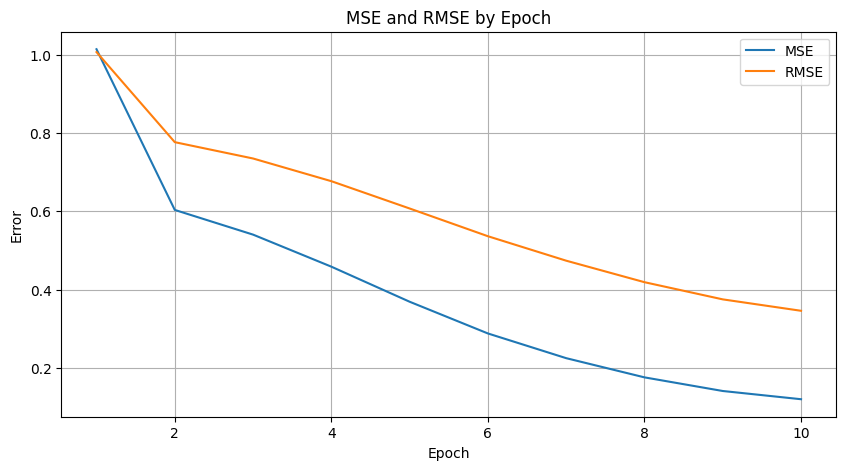

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length
        self.target_columns = ['score']

        # Drop NaNs
        self.data.dropna(subset=self.target_columns, inplace=True)

        # Convert target columns to float, and handle possible conversion issues
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors='coerce')
        self.data.dropna(subset=self.target_columns, inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']
        targets = self.data.iloc[idx][self.target_columns].tolist()

        # Tokenize text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(targets, dtype=torch.float)
        }

# Load tokenizer and initialize dataset
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_df.dropna(subset=['full_text'], inplace=True)  # Ensure no NaNs in 'full_text'
train_dataset = CustomDataset(train_df, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the model
class RobertaRegressionModel(nn.Module):
    def __init__(self):
        super(RobertaRegressionModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.regressor = nn.Linear(self.roberta.config.hidden_size, 1)  #  1 target features

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output)



import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaRegressionModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

# Storage for plot data
epoch_count = 10
mse = []
rmse = []

# Training loop
model.train()
for epoch in range(epoch_count):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {average_loss}')
    mse.append(average_loss)
    rmse.append(np.sqrt(average_loss))

# Plotting MSE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch_count+1), mse, label='MSE')
plt.plot(range(1, epoch_count+1), rmse, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('MSE and RMSE by Epoch')
plt.legend()
plt.grid(True)
#plt.savefig('/content/drive/MyDrive/model_performance_metrics.png')
plt.show()

# Saving the metrics to a file
#metrics_path = '/content/drive/MyDrive/model_metrics.npy'
#np.save(metrics_path, np.array([mse, rmse]))
#print(f"Metrics saved to {metrics_path}")

In [13]:
 #Save the model weights to a file
torch.save(model.state_dict(), 'roberta_regression_model_weights.pt')

In [21]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer

# Custom dataset class for the test data
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']

        # Tokenize text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

# Load the test data
test_data = pd.read_csv('/kaggle/input/dataset/test.csv')  # Path to test data
sample_submission = pd.read_csv('/kaggle/input/dataset/sample_submission.csv')  # Path to sample submission file

# Initialize tokenizer and test dataset
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
test_dataset = CustomTestDataset(test_data, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaRegressionModel().to(device)
model.load_state_dict(torch.load('/kaggle/working/roberta_regression_model_weights.pt'))  # Adjust the path
model.eval()

# Perform predictions
predicted_scores = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask).squeeze(-1)
        predicted_scores.extend(outputs.cpu().numpy())

# Add predictions to the test data
test_data['predicted_score'] = predicted_scores

# Merge with actual scores
result = test_data.merge(sample_submission, on='essay_id', how='left')
result.rename(columns={'score': 'actual_score'}, inplace=True)

# Display the first few rows of predicted and actual scores
print(result[['essay_id', 'predicted_score', 'actual_score']].head())

# Save the merged results to a file
#output_path = '/content/drive/MyDrive/test_results_with_actual.csv'
#result[['essay_id', 'predicted_score', 'actual_score']].to_csv(output_path, index=False)
#print(f"Results with actual scores saved to {output_path}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_23/3581246143.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

  essay_id  predicted_score  actual_score
0  000d118         3.828271             3
1  000fe60         3.162828             3
2  001ab80         3.775258             4


In [15]:
def predict_single_essay(essay_text, model, tokenizer, max_length=128):
    """
    Predicts scores for a single essay using the trained model.

    Parameters:
    - essay_text: The essay text as a string.
    - model: The trained PyTorch model.
    - tokenizer: The tokenizer used for preprocessing.
    - max_length: Maximum token length for the model.

    Returns:
    - Predicted scores as a dictionary.
    """
    model.eval()

    # Tokenize the essay
    inputs = tokenizer.encode_plus(
        essay_text,
        None,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict using the model
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = torch.round(outputs.cpu()).numpy().flatten()  # Round to integers

    # Map scores to categories
    categories = ['score']
    scores_dict = dict(zip(categories, predicted_scores))

    return scores_dict

# Example essay to test
essay_text = """
Environment is important. We need to save it. Pollution is bad. Trees are good. People should stop cutting trees. 
More trees will help the earth. Climate change is a problem. Everyone needs to do better. That's all.
"""



# Load the trained model
model = RobertaRegressionModel().to(device)
model.load_state_dict(torch.load('/kaggle/working/roberta_regression_model_weights.pt'))  # Adjust path

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Predict scores for the essay
predicted_scores = predict_single_essay(essay_text, model, tokenizer)

# Display the results
print("Predicted Scores for the Essay:")
for category, score in predicted_scores.items():
    print(f"{category}: {int(score)}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_23/1414923108.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

Predicted Scores for the Essay:
score: 2


In [19]:
def predict_single_essay(essay_text, model, tokenizer, max_length=128):
    """
    Predicts the overall score for a single essay using the trained model.

    Parameters:
    - essay_text: The essay text as a string.
    - model: The trained PyTorch model.
    - tokenizer: The tokenizer used for preprocessing.
    - max_length: Maximum token length for the model.

    Returns:
    - Predicted overall score (integer).
    """
    model.eval()

    # Tokenize the essay
    inputs = tokenizer.encode_plus(
        essay_text,
        None,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict using the model
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_score = torch.round(outputs.cpu()).item()  # Convert to integer

    return int(predicted_score)

# Example low-quality essay
essay_text = """
The Importance of Environmental Conservation
In an era of rapid industrialization and urbanization, the importance of environmental conservation cannot be overstated. Our planet’s natural resources are finite, and their depletion is accelerating at an alarming rate due to human activities. Preserving the environment is not just a moral obligation but a necessity for ensuring the survival of future generations.

Environmental conservation involves protecting ecosystems, reducing pollution, and promoting sustainable practices. Forests, for example, act as the lungs of our planet, absorbing carbon dioxide and releasing oxygen. However, deforestation for agriculture and urban expansion threatens this vital balance. By conserving forests, we not only protect biodiversity but also mitigate climate change.

Water conservation is equally crucial. With freshwater resources dwindling in many parts of the world, efficient water management and pollution control can help address shortages and ensure access for all. Similarly, reducing the use of fossil fuels and transitioning to renewable energy sources can significantly cut greenhouse gas emissions and curb global warming.

Individuals also play a critical role in environmental conservation. Simple actions such as recycling, reducing waste, and using energy-efficient appliances can collectively make a substantial impact. Governments and organizations must enforce policies and create awareness to foster a culture of sustainability.

In conclusion, environmental conservation is a shared responsibility. By taking conscious steps today, we can preserve the Earth’s beauty and resources for generations to come. Our collective efforts can transform the vision of a sustainable future into reality.


"""

# Predict score for the essay
predicted_score = predict_single_essay(essay_text, model, tokenizer)

# Display the result
print(f"Predicted Score for the Essay: {predicted_score}")


Predicted Score for the Essay: 5


In [22]:
from sklearn.metrics import mean_squared_error

y_pred = [3.83, 3.16, 3.78]  # Predicted scores
y_true = [3, 3, 4]           # Actual scores
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MSE: 0.2543
RMSE: 0.5043


In [ ]:
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
print(inputs)